# **Hyperparameter Optimisation**

### Maximising Model Performance Via Hyperparameter Selection

The performance of a trained machine learning model can be very sensitive to the hyperparameter settings and thus it is important for the model owner to choose settings carefully in order to maximise the model’s efficacy (‘hyperparameter optimisation’).

In this notebook, we will:


1.   Generate and visualise synthetic data to be used for the downstream tasks
2.   Declare hyperparameter search spaces
3.   Perform hyperparameter search using the three-way holdout method for validation
4.   Perform hyperparameter search using the *k*-fold cross-validation method

For each of steps 2 and 3, we will work through four hyperparameter search methods:

*   Random search
*   Grid search
*   Bayesian optimisation
*   Evolutionary algorithms

This notebook should be read in conjunction with the Hyperparameter Optimisation document which can be found here [link to be finalised]. 

### <font color='red'>Install missing modules

In [ ]:
!pip install tpot

     |████████████████████████████████| 87 kB 3.1 MB/s 
     |████████████████████████████████| 160 kB 31.8 MB/s 
     |████████████████████████████████| 173.6 MB 7.6 kB/s 
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11956 sha256=3b1691895b70cc69269f27747d968d8b861a087c779436ffacc4b6b279dbfd40
  Stored in directory: /root/.cache/pip/wheels/e2/d2/79/eaf81edb391e27c87f51b8ef901ecc85a5363dc96b8b8d71e3
Successfully built stopit
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


### <font color='red'>Import modules/functions

In [ ]:
import numpy as np

# Scikit-learn imports
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterSampler, ParameterGrid, RandomizedSearchCV, GridSearchCV, KFold, StratifiedKFold

# Matplotlib imports
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Hyperopt imports (for Bayesian optimisation)
import hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

# TPOT import (for evolutionary algorithms)
from tpot import TPOTClassifier

# <font color='deepskyblue'>Generate and visualise synthetic data

### <font color='red'>Generate synthetic data

We create binary data which overlaps. Changing 'cluster_std' causes the data to overlap more widely making it more difficult for a classifier to separate the two classes.

In [ ]:
# generate synthetic data
X, Y = make_blobs(n_samples = 1000, centers=2, n_features=50, cluster_std=30)
# scale the features
X = StandardScaler().fit_transform(X)

### <font color='red'>Display data

We perform PCA analysis in order to isolate the data features which show the greatest variability. We then graph in 2D and 3D to get some intuition of how the data appears.

In [ ]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X)

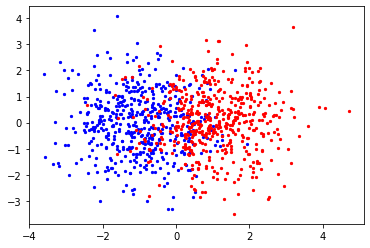

In [ ]:
plt.scatter(principalComponents[np.where(Y==0),0], principalComponents[np.where(Y==0),1], s=5, color='blue')
plt.scatter(principalComponents[np.where(Y==1),0], principalComponents[np.where(Y==1),1], s=5, color='red')
plt.show()

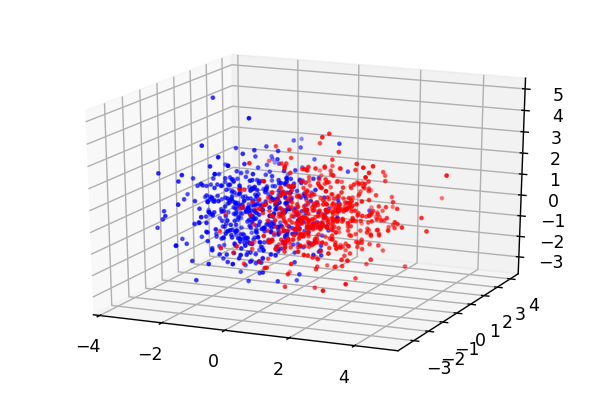

In [ ]:
%matplotlib inline

fig = plt.figure(dpi=125)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(principalComponents[np.where(Y==0),0], principalComponents[np.where(Y==0),1],\
           principalComponents[np.where(Y==0),2], s=3, color='blue')
ax.scatter(principalComponents[np.where(Y==1),0], principalComponents[np.where(Y==1),1],\
           principalComponents[np.where(Y==1),2], s=3, color='red')
ax.view_init(elev=20, azim=-66)

# <font color='deepskyblue'>Declare hyperparameter spaces for the four hyperparameter search methods

### <font color='red'>Define hyperparameter grid for random search and grid search

- to be used for both random search and grid search
- used for the three-way holdout method, k-fold cross-validation and LOOCV

In [ ]:
paramGrid = {'max_features': list(np.linspace(1,25,5, dtype = int)),
              'n_estimators': list(np.linspace(10,100,10, dtype = int))} 

### <font color='red'>Define hyperparameter space for Bayesian optimisation
- we use the same parameter range as before, but this version is for use specifically by the Hyperopt package for Bayesian optimisation
- used for the three-way holdout method, k-fold cross-validation and LOOCV

In [ ]:
bayesianSpace = {'max_features': hp.choice('max_features',list(np.linspace(1,25,5, dtype = int))),
              'n_estimators': hp.choice('n_estimators',list(np.linspace(10,100,10, dtype = int)))}

### <font color='red'>Define hyperparameter space for Evolutionary Algorithms
- we use the same parameter range as before, but this version includes the random state (as the random state isn't passed as an explicit argument to the TPOT function call)
- used for the three-way holdout method, k-fold cross-validation and LOOCV

In [ ]:
EAparamGrid = {'max_features': list(np.linspace(1,25,5, dtype = int)),
              'n_estimators': list(np.linspace(10,100,10, dtype = int)),
              'random_state': list(np.linspace(42,42,1, dtype = int))} 

# <font color='deepskyblue'>Three-way holdout method

As per the Hyperparameter Optimisation document, the three-way holdout method is best only used for large datasets, where the complete exclusion of the validation set for model training (parameter learning) only causes minimal learning impact.

### Split the dataset three ways

In [ ]:
# split dataset for three-way holdout method
combinedTrainX, testX, combinedTrainY, testY = train_test_split(X, Y, test_size = 0.20, random_state = 42)
trainX, validX, trainY, validY = train_test_split(combinedTrainX, combinedTrainY, test_size = 0.25, random_state = 42)

### Training and validation loop for random search and grid search

In [ ]:
def trainingLoop_randomGrid(paramList):

    searchResults = np.zeros((len(paramList), len(paramGrid)+1))

    for i, params in enumerate(paramList):
        model = RandomForestClassifier(**params, random_state=42)
        model.fit(trainX, trainY)
        predictions = model.predict(validX)
        acc = accuracy_score(predictions, validY)

        for j in range(len(params)):
            searchResults[i,j] = list(params.values())[j]
        searchResults[i,-1] = acc

    return searchResults

## <font color='red'>Three-way holdout method - random search

### Create random sample of hyperparameter sets

In [ ]:
randomParamList = ParameterSampler(param_distributions=paramGrid, n_iter=10, random_state=42)

### Find the hyperparameters from the random sample that returns the best performance (accuracy)

In [ ]:
randomSearchResults = trainingLoop_randomGrid(randomParamList)
bestParams = list(randomParamList)[np.argmax(randomSearchResults[:,-1])]
bestParams

{'max_features': 7, 'n_estimators': 80}

### Retrain model using the 'best hyperparameters' on the combined training and validation sets and compute expected generalisation error over the test set

In [ ]:
model = RandomForestClassifier(**bestParams, random_state=42)
model.fit(combinedTrainX, combinedTrainY)
predictions = model.predict(testX)
acc = accuracy_score(predictions, testY)
acc

0.84

### Retrain model using the 'best hyperparameters' over the entire dataset

This step generates a model which uses the largest amount of training data possible. However, doing as such precludes the use of a holdout set and thus an expected generalisation error at this step cannot be computed.

In [ ]:
model = RandomForestClassifier(**bestParams, random_state=42)
model.fit(X, Y)

RandomForestClassifier(max_features=7, n_estimators=80, random_state=42)

## <font color='red'>Three-way holdout method - grid search

### Create list of all hyperparameter sets than can be generated from the grid

In [ ]:
gridParamList = ParameterGrid(param_grid=paramGrid)

### Find the hyperparameters from the random sample that returns the best performance (accuracy)

In [ ]:
gridSearchResults = trainingLoop_randomGrid(gridParamList)
bestParams = list(gridParamList)[np.argmax(gridSearchResults[:,-1])]
bestParams, max(gridSearchResults[:,-1])

({'max_features': 7, 'n_estimators': 50}, 0.755)

### Retrain model using the 'best hyperparameters' on the combined training and validation sets and compute expected generalisation error over the test set

In [ ]:
model = RandomForestClassifier(**bestParams, random_state=42)
model.fit(combinedTrainX, combinedTrainY)
predictions = model.predict(testX)
acc = accuracy_score(predictions, testY)
acc

0.77

### Retrain model using the 'best hyperparameters' over the entire dataset

This step generates a model which uses the largest amount of training data possible. However, doing as such precludes the use of a holdout set and thus an expected generalisation error at this step cannot be computed.

In [ ]:
model = RandomForestClassifier(**bestParams, random_state=42)
model.fit(X, Y)

RandomForestClassifier(max_features=7, n_estimators=50, random_state=42)

## <font color='red'>Three-way holdout method - Bayesian optimisation

### Training and validation function for Bayesian optimisation

In [ ]:
def objective(bayesianSpace):
    model = RandomForestClassifier(max_features = bayesianSpace['max_features'], n_estimators = bayesianSpace['n_estimators'], random_state=42)
    model.fit(trainX, trainY)
    predictions = model.predict(validX)
    acc = accuracy_score(predictions, validY)
    
    return {'loss': -acc, 'status':STATUS_OK}

### Find the 'best hyperparameters' generated by the Bayesian optimisation process

In [ ]:
trials = Trials()
best = fmin(fn=objective, space=bayesianSpace, algo=tpe.suggest, max_evals=50, trials=trials)
bestParams = hyperopt.space_eval(bayesianSpace, best)
bestParams

100%|██████████| 50/50 [00:09<00:00,  5.35trial/s, best loss: -0.755]


{'max_features': 7, 'n_estimators': 50}

### Retrain model using the 'best hyperparameters' on the combined training and validation sets and compute expected generalisation error over the test set

In [ ]:
model = RandomForestClassifier(**bestParams, random_state=42)
model.fit(combinedTrainX, combinedTrainY)
predictions = model.predict(testX)
acc = accuracy_score(predictions, testY)
acc

0.77

### Retrain model using the 'best hyperparameters' over the entire dataset

This step generates a model which uses the largest amount of training data possible. However, doing as such precludes the use of a holdout set and thus an expected generalisation error at this step cannot be computed.

In [ ]:
model = RandomForestClassifier(**bestParams, random_state=42)
model.fit(X, Y)

RandomForestClassifier(max_features=7, n_estimators=50, random_state=42)

## <font color='red'>Three-way holdout method - evolutionary algorithms

The TPOT functions naturally perform *k*-fold cross-validation. We create a predefined split of the data to feed to the TPOT function to override this behaviour.

In [ ]:
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import make_scorer

combinedTrainX_appended = np.concatenate((combinedTrainX, np.arange(0, len(combinedTrainX)).reshape(-1,1)), axis=1)

# split dataset for three-way holdout method
trainX_appended, validX_appended, trainY, validY = train_test_split(combinedTrainX_appended, combinedTrainY, test_size = 0.25, random_state = 42)

foldList = np.zeros((len(combinedTrainX),1))
foldList[trainX_appended[:,-1].astype(int),0] = -1
foldList[validX_appended[:,-1].astype(int),0] = 0

ps = PredefinedSplit(foldList)

# Make a custom metric function
def my_custom_accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

# # Make a custom a scorer from the custom metric function
# # Note: greater_is_better=False in make_scorer below would mean that the scoring function should be minimized.
my_custom_scorer = make_scorer(my_custom_accuracy, greater_is_better=True)

###Use the TPOT module to perform the hyperparameter search using evolutionary algorithms

In [ ]:
bestEAmodel = TPOTClassifier(template='Classifier', generations=2, population_size=5, random_state=42, verbosity=2, \
                             config_dict={'sklearn.ensemble.RandomForestClassifier': EAparamGrid}, \
                             scoring=my_custom_scorer, cv=ps.split())
bestEAmodel.fit(combinedTrainX, combinedTrainY)
bestEAmodel.score(validX_appended[:,:-1], validY)

Optimization Progress:   0%|          | 0/15 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.76

Generation 2 - Current best internal CV score: 0.76

Best pipeline: RandomForestClassifier(input_matrix, max_features=13, n_estimators=80, random_state=42)


1.0

### Retrain model using the 'best hyperparameters' on the training set and compute expected generalisation error over the validation set

In [ ]:
model = list(bestEAmodel.fitted_pipeline_.steps)[0][1]
model.fit(trainX, trainY)
predictions = model.predict(validX)
acc = accuracy_score(predictions, validY)
acc

0.745

### Retrain model using the 'best hyperparameters' on the combined training and validation sets and compute expected generalisation error over the test set

In [ ]:
model = list(bestEAmodel.fitted_pipeline_.steps)[0][1]
model.fit(combinedTrainX, combinedTrainY)
predictions = model.predict(testX)
acc = accuracy_score(predictions, testY)
acc

0.74

### Retrain model using the 'best hyperparameters' over the entire dataset

This step generates a model which uses the largest amount of training data possible. However, doing as such precludes the use of a holdout set and thus an expected generalisation error at this step cannot be computed.

In [ ]:
model = list(bestEAmodel.fitted_pipeline_.steps)[0][1]
model.fit(X, Y)

RandomForestClassifier(max_features=13, n_estimators=80, random_state=42)

# <font color='deepskyblue'>*k*-fold cross-validation

*k*-fold cross-validation (including the special case when *k* is set to equal *n*, referred to as 'Leave-One-Out Cross-Validation' or LOOCV for short) is well-suited for use over smaller datasets where it is best to show as much of the available data as possible to the learning algorithm.

### Split the dataset two ways

In [ ]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.20, random_state = 42)

## <font color='red'>*k*-fold cross-validation - random search and grid search

### Find the hyperparameters from the random sample that returns the best performance (accuracy)

In the cell below, calls to both the randomised search function and the grid search function are given. Please comment out the function (with # at the start of the line) that you do not wish to use).

In [ ]:
cv = KFold(n_splits=5)

model = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42), random_state=42, param_distributions=paramGrid, n_iter=10, cv=cv)
# model = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=paramGrid, cv=cv)

model.fit(trainX, trainY)
bestParams = model.best_params_
bestParams, model.best_score_

({'n_estimators': 70, 'max_features': 13}, 0.73)

### Retrain model using the 'best hyperparameters' on the full training set and compute expected generalisation error over the test set

In [ ]:
model = RandomForestClassifier(**bestParams, random_state=42)
model.fit(trainX, trainY)
predictions = model.predict(testX)
acc = accuracy_score(predictions, testY)
acc

0.755

### Retrain model using the 'best hyperparameters' over the entire dataset

This step generates a model which uses the largest amount of training data possible. However, doing as such precludes the use of a holdout set and thus an expected generalisation error at this step cannot be computed.

In [ ]:
model = RandomForestClassifier(**bestParams, random_state=42)
model.fit(X, Y)

RandomForestClassifier(max_features=13, n_estimators=70, random_state=42)

## <font color='red'>*k*-fold cross-validation - Bayesian optimisation

### Generate folds to be used by the Bayesian optimisation objective function

In [ ]:
# kf = KFold(n_splits=5)

kf = StratifiedKFold(n_splits=5)

### Training and validation function for Bayesian optimisation

In [ ]:
def objective(bayesianSpace):
    model = RandomForestClassifier(max_features = bayesianSpace['max_features'], n_estimators = bayesianSpace['n_estimators'], random_state=42)
    
    cumulativeAcc = 0
    
    for train_index, test_index in kf.split(trainX, trainY):
        trainX_cv, validX_cv = trainX[train_index], trainX[test_index]
        trainY_cv, validY_cv = trainY[train_index], trainY[test_index]
    
        model.fit(trainX_cv, trainY_cv)
        predictions = model.predict(validX_cv)
        acc = accuracy_score(predictions, validY_cv)
        
        cumulativeAcc += acc
    
    acc /= kf.n_splits
    
    return {'loss': -acc, 'status':STATUS_OK}

### Find the 'best hyperparameters' generated by the Bayesian optimisation process

In [ ]:
trials = Trials()
best = fmin(fn=objective, space=bayesianSpace, algo=tpe.suggest, max_evals=10, trials=trials)
bestParams = hyperopt.space_eval(bayesianSpace, best)
bestParams

100%|██████████| 10/10 [00:05<00:00,  1.94trial/s, best loss: -0.16375]


{'max_features': 7, 'n_estimators': 100}

### Retrain model using the 'best hyperparameters' on the combined training and validation sets and compute expected generalisation error over the test set

In [ ]:
model = RandomForestClassifier(**bestParams, random_state=42)
model.fit(combinedTrainX, combinedTrainY)
predictions = model.predict(testX)
acc = accuracy_score(predictions, testY)
acc

0.79

### Retrain model using the 'best hyperparameters' over the entire dataset

This step generates a model which uses the largest amount of training data possible. However, doing as such precludes the use of a holdout set and thus an expected generalisation error at this step cannot be computed.

In [ ]:
model = RandomForestClassifier(**bestParams, random_state=42)
model.fit(X, Y)

RandomForestClassifier(max_features=7, random_state=42)

## <font color='red'>*k*-fold cross-validation - evolutionary algorithms

Declare the number of folds to be used by the TPOT function together with the evaluation metric (accuracy).

In [ ]:
from sklearn.metrics import make_scorer

cv = KFold(n_splits=5)

# Make a custom metric function
def my_custom_accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

# # Make a custom a scorer from the custom metric function
# # Note: greater_is_better=False in make_scorer below would mean that the scoring function should be minimized.
my_custom_scorer = make_scorer(my_custom_accuracy, greater_is_better=True)

###Use the TPOT module to perform the hyperparameter search using evolutionary algorithms

In [ ]:
bestEAmodel = TPOTClassifier(template='Classifier', generations=2, population_size=5, random_state=42, verbosity=2, \
                             config_dict={'sklearn.ensemble.RandomForestClassifier': EAparamGrid}, \
                             scoring=my_custom_scorer, cv=cv)
bestEAmodel.fit(trainX, trainY)

Optimization Progress:   0%|          | 0/15 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.74

Generation 2 - Current best internal CV score: 0.74

Best pipeline: RandomForestClassifier(input_matrix, max_features=13, n_estimators=80, random_state=42)


TPOTClassifier(config_dict={'sklearn.ensemble.RandomForestClassifier': {'max_features': [1,
                                                                                         7,
                                                                                         13,
                                                                                         19,
                                                                                         25],
                                                                        'n_estimators': [10,
                                                                                         20,
                                                                                         30,
                                                                                         40,
                                                                                         50,
                                                                       

### Retrain model using the 'best hyperparameters' on the combined training and validation sets and compute expected generalisation error over the test set

In [ ]:
model = list(bestEAmodel.fitted_pipeline_.steps)[0][1]
model.fit(trainX, trainY)
predictions = model.predict(testX)
acc = accuracy_score(predictions, testY)
acc

0.74

### Retrain model using the 'best hyperparameters' over the entire dataset

This step generates a model which uses the largest amount of training data possible. However, doing as such precludes the use of a holdout set and thus an expected generalisation error at this step cannot be computed.

In [ ]:
model = list(bestEAmodel.fitted_pipeline_.steps)[0][1]
model.fit(X, Y)

RandomForestClassifier(max_features=13, n_estimators=80, random_state=42)